Refined RMSE with Select Weather: 0.82


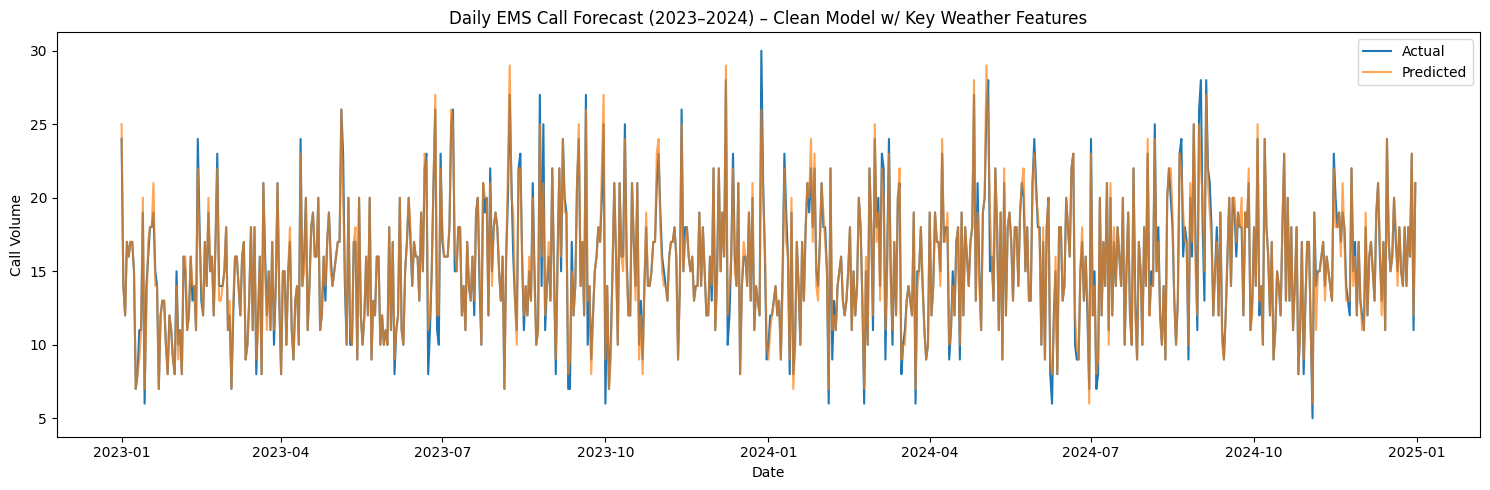

In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Call Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Download Weather (Only once needed) ---
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    "latitude": 39.1857,
    "longitude": -78.1633,
    "start_date": "2017-01-01",
    "end_date": "2024-12-31",
    "daily": ["temperature_2m_max", "temperature_2m_mean"],
    "timezone": "America/New_York"
}
response = requests.get(url, params=params)
data = response.json()

weather = pd.DataFrame(data["daily"])
weather['time'] = pd.to_datetime(weather['time'])
weather.rename(columns={
    'time': 'date',
    'temperature_2m_max': 'max_temp',
    'temperature_2m_mean': 'avg_temp'
}, inplace=True)

# --- 3. Merge Weather with EMS Data ---
daily = daily.merge(weather, on='date', how='left')

# --- 4. Create Top Weather Lags Only ---
daily['max_temp_lag1'] = daily['max_temp'].shift(1)
daily['avg_temp_lag1'] = daily['avg_temp'].shift(1)

# --- 5. Calendar & Call Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# Lag + rolling
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# Holiday/weekend
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 6. Clean Up ---
daily.dropna(inplace=True)

# --- 7. Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy',
    'avg_temp_lag1', 'max_temp_lag1'  # selectively added weather
]

# --- 8. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 9. Train Model ---
model = HistGradientBoostingRegressor(
    loss='poisson',
    max_iter=300,
    learning_rate=0.05,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)
model.fit(X_train, y_train)

# --- 10. Predict & Evaluate ---
preds_log = model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Refined RMSE with Select Weather: {rmse:.2f}")

# --- 11. Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Clean Model w/ Key Weather Features')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()
